https://github.com/opendatacube/odc-tools/blob/develop/notebooks/geomedian-example.ipynb

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import hdstats
import odc.algo



In [2]:
from datacube.utils.rio import configure_s3_access
from datacube.utils.dask import start_local_dask
import os
import dask
from dask.utils import parse_bytes

# configure dashboard link to go over proxy
dask.config.set({"distributed.dashboard.link":
                 os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

# Figure out how much memory/cpu we really have (those are set by jupyterhub)
cpu_limit = float(os.environ.get('CPU_LIMIT', '0'))
cpu_limit = int(cpu_limit) if cpu_limit > 0 else 4

# close previous client if any, so that one can re-run this cell without issues
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = start_local_dask(n_workers=1,
                          threads_per_worker=cpu_limit, 
                          mem_safety_margin='4G')
display(client)

# Configure GDAL for s3 access 
configure_s3_access(aws_unsigned=True,  # works only when reading public resources
                    client=client);

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 35.12 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33925,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 35.12 GiB
Comm: tcp://127.0.0.1:35487,Total threads: 4
Dashboard: /proxy/39653/status,Memory: 35.12 GiB
Nanny: tcp://127.0.0.1:38335,


In [3]:
from glob import glob
from pathlib import Path
from utils import *

In [4]:
vi = 'raw'
run = 'f6'
# outf = f'/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/raster/{run}'
# folder = '/home/geodata/Clientes/0FARMS/FabioRicardi-Barreiras_BA/nc/f5/'

outf = f'/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/raster/{run}/'
folder = '/home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f5/'


Path(outf).mkdir( parents = True, exist_ok = True)

ff = sorted(glob(folder+f'{vi}*.nc'))
print(len(ff),'\n',ff[0],'\n',ff[-1])

39 
 /home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f5/raw_1985-06-21_1986-06-21.nc 
 /home/geodata/Clientes/0FARMS/MG-3102605-B4D344DBFD874F44906FCC0A5E0DCE36/nc/f5/raw_2023-06-22_2024-06-05.nc


In [30]:
ds = xr.open_dataset(ff[-1])

In [31]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                       (longitude: 36, latitude: 22, time: 39)
Coordinates: (12/19)
  * longitude                     (longitude) float64 288B -46.65 ... -46.64
  * latitude                      (latitude) float64 176B -22.07 ... -22.08
    accuracy:geometric_y_bias     int64 8B ...
    landsat:scene_id              (time) <U21 3kB ...
    updated                       (time) <U24 4kB ...
    card4l:specification          <U2 8B ...
    ...                            ...
    id                            (time) <U43 7kB ...
    landsat:collection_category   <U2 8B ...
    proj:epsg                     int64 8B ...
    view:sun_azimuth              (time) float64 312B ...
    full_width_half_max           float64 8B ...
    epsg                          int64 8B ...
Data variables:
    spatial_ref                   int64 8B ...
    red                           (time, latitude, longitude) float64 247kB ...
    blue                          (time, latitude, longitude) float64 247kB ...
    nir08                         (time, latitude, longitude) float64 247kB ...
    swir16                        (time, latitude, longitude) float64 247kB ...
Attributes:
    transform:      [ 2.91676295e-04  0.00000000e+00 -4.66489565e+01  0.00000...
    resolution_xy:  [0.00029168 0.00027461]

In [32]:
data_bands = ['red', 'blue', 'nir08','swir16']

In [33]:
from datacube import Datacube
from odc.algo import fmask_to_bool, to_f32, from_float, xr_geomedian

In [34]:
xx = ds[data_bands].astype('float32')

In [35]:
scale, offset = (1/1, 0)  # differs per product, aim for 0-1 values in float32

# no_cloud = fmask_to_bool(xx.fmask, ('valid', 'snow', 'water'))

# xx_data = xx[data_bands]
# xx_clean = odc.algo.keep_good_only(xx_data, where=no_cloud)
# xx_clean = to_f32(xx_clean, scale=scale, offset=offset)
yy = xr_geomedian(xx, 
                  num_threads=8,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

yy = from_float(yy, 
                dtype='int16', 
                nodata=-999, 
                scale=1/scale, 
                offset=-offset/scale)

In [36]:
yy = yy.compute()


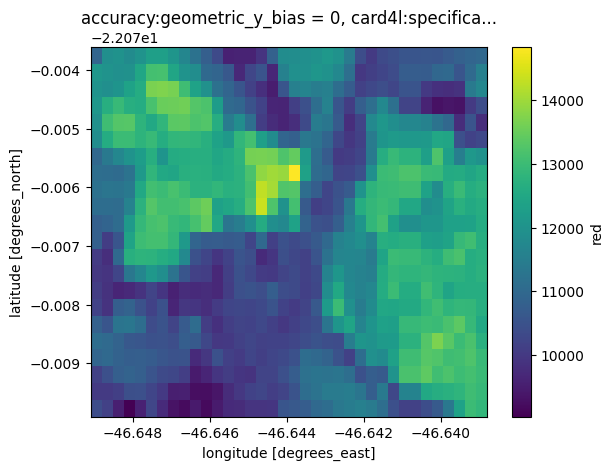

In [37]:
ds['red'].median(dim='time').plot()

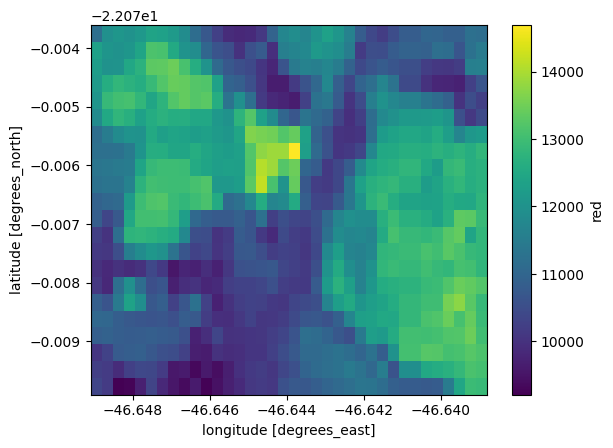

In [38]:
yy['red'].plot()

In [13]:
from odc.ui import to_png_data
from IPython.display import Image

rgba = odc.algo.to_rgba(yy, clamp=3000, bands = ['red', 'blue', 'nir08'])
Image(data=to_png_data(rgba.data))

/home/mariano/geo/lib/python3.10/site-packages/odc/algo/_rgba.py:67: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  valid = np.ones(r.shape, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations